In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## module_F0

In [ ]:
# module_fm_demodulation.py
# D. Gibbon,
# Created 2021-07-11
# Modified 2022-04-18

"""
FM demodulation (F0 estimation, pitch tracking)

Preprocessing:
	centre and peak clipping
	Butterworth low pass filter

FM demodulation:
	The algorithm is the AMDF (Absolute Magnitude Difference Function).
	Often known as the Average Magnitude Difference Function.
	In this interpretation of AMDF, the sum, not the average is used.
	Four Pythonic and Non-Pythonic implementations are given.
	Algorithm:
	Moving window from frame to frame through the signal
		- frame duration dependent on selected minimum F0
		- skip interval to next frame is selectable
		- moving window through frame and neighbour
			- offset avoids initial zero, depends on selected max F0
			- sum of differences between window and frame
		- min distance: argmin, add offset, convert to period & frequency
- SMDF, Summed Magnitude Difference Function (variant of AMDF, Average ...)
- This implementation simply uses the sum of differences: simpler and faster
- Instead of "abs" "square" could be used, yielding the ASDF
- The difference is minimal, on a quick test ASDF seems a little cleaner.
- The choice is up to the user.

F0 estimation parameter guesstimation (adjust if you know what you are doing):
- Signal pre-forming,  F0 post-forming settings
- The "female" and "male" options are just general settings.
- The f0min and f0max values can be set to whatever is convenient.
- f0min co-determines the AMDF offset
- f0max co-determines the length of the frame
Four algorithm styles are provided, user selectable: A, B, C, D.
"""

#===============================================================

import numpy as np
from scipy.signal import butter, lfilter, medfilt, tukey

#===============================================================
# The voice variable is just a mnemonic convenience.
voice = "male"

if voice == "male":
	# Male default settings
	f0min =100
	f0max = 300
elif voice == "female":
	# Female default settings
	f0min = 110
	f0max = 350
else:
	# General default settings
	f0min = 70
	f0max = 420

f0medfilter = 3

f0framelengthfactor = 0.75							# relative to f0min, > 1
f0frameskipfactor = 0.5								# resolution, default is 1, the frame length

# Frame, offset and window shape definition
f0frameduration =  1 / f0min
f0frameduration = f0framelengthfactor * f0frameduration
framerate = 2 / f0frameduration						# 2 is because of the fs/2 spectrum resolution

f0diffoffsetlengthfactor = 0.1
f0diffoffsetduration = f0diffoffsetlengthfactor / f0max	# duration in seconds, relative to f0max

#===============================================================
# Centre and peak clipping (adjust if you know what you are doing)

centrethresh = 0.1			# Deals with silence and low volume noise
limitthresh = 0.9

#===============================================================
# Butterworth bandpass filter (adjust if you know what you are dong)

fmbutterhigh = f0min * 2
fmbutterhighorder = 5
fmbutterlow = f0max
fmbutterloworder = 2

#===============================================================
# Butterworth filter

def butterworthfilter(signaldata, cutoff, order, fs, type):

	nyqvist = 0.5 * fs
	normal_cutoff = cutoff / nyqvist
	b, a = butter(order, normal_cutoff, btype=type, analog=False)
	filteredsignal = lfilter(b, a, signaldata)

	return filteredsignal

#===============================================================
# Zero clipping and peak clipping

def clipper(sig,thresh,type):
	if type == "centre":
		clipped = (abs(sig) > thresh).astype(int) * sig
	elif type == "limit":
		clipped = (abs(sig) < thresh).astype(int) * sig
	elif type == "lower":
		clipped = (sig > thresh).astype(int) * sig
	elif type == "upper":
		clipped = (sig < thresh).astype(int) * sig
	else:
		print("Unknown type:",type); sys.exit()
	return np.asarray(clipped)

#===============================================================
#===============================================================

def f0amdf(signal, fs, framestart, framelength, f0diffoffsetlength, algo):

	"""
AMDF FM demodulation (F0 estimation, 'pitch' extraction) for one frame

If multiplication is used instead of subtraction, and argmax instead of argmin, the 	implementations are effectively cross-correlation variants.
"""

	# Define the end of the current frame
	# Define the range of the lag window
	# from the frame start plus offset to frame end
	framestop = framestart + framelength
	movingwindowrange = np.arange(framestart+f0diffoffsetlength, framestop)

	# Make a list of differences between the frame and lag frame
	# The comparison starts after an offset
	# to avoid the identity of frame and zero lag frame
	# The sums of the differences are collected
	# in a list using a Python comprehension loop

	#==================================================
	# "There's more than one way to do it!"
	#==================================================

	# Pythonic comprehension, calculations in loop
	if algo == "A":
		diffsums = [
			np.sum(np.abs(signal[framestart:framestop] - signal[winstart:winstop]))
			for winstart, winstop in zip(movingwindowrange, movingwindowrange+framelength) ]

#===============================================================
	# Pythonic comprehension, calculations outside loop
# Version B is on average slightly faster than the others.
	elif algo == "B":
		frame = signal[framestart:framestop]
		movingwindows =  zip(movingwindowrange, movingwindowrange+framelength)
		diffsums = [
			np.sum(np.abs(frame - signal[winstart:winstop]))
			for winstart, winstop in movingwindows ]

#===============================================================
	# Classic for-loop with output list construction
	elif algo == "C":
		frame = signal[framestart:framestop]
		movingwindows =  zip(movingwindowrange, movingwindowrange+framelength)
		diffsums = []
		for winstart, winstop in movingwindows:
			diffsums += [
				np.sum(np.abs(frame - signal[winstart:winstop])) ]

#===============================================================
	# Classic for-loop with pre-defined empty output list
	elif algo == "D":
		frame = signal[framestart:framestop]
		movingwindows =  zip(movingwindowrange, movingwindowrange+framelength)
		diffsums = np.zeros(len(movingwindowrange))
		for i, (winstart, winstop) in enumerate(movingwindows):
			diffsums[i] = np.sum(np.abs(frame - signal[winstart:winstop]))

#===============================================================
	"""
- The position of the first smallest difference in the sums of differences is calculated and added to the offset position in order to determine period estimate (in samples).
- The period estimate is divided by the sampling rate to obtain the period estimate in seconds.
- The inverse of the period estimate is calculated in order to find the F0 estimate.
	"""
	f0 = 1 / ( (np.argmin(diffsums) + f0diffoffsetlength) / fs )

	return f0

#===============================================================
#===============================================================
# Move through the signal from frame to frame, calling the AMDF function

def f0estimate(signal,fs):

	"""
AMDF:
- frame duration is defined relative to specified f0min (the frame has to be long enough 	to capture low frequencies with long periods), and a frame length factor for fine tuning
- start offset duration for difference calculation is defined relative to specified f0max; it has to be just far enough from the frame start so as not to be further than the short period of the maximum frequency), and a length factor for fine tuning
	"""

	framelength = int(f0frameduration * fs)
	frameskip = int(framelength * f0frameskipfactor)

	f0diffoffsetlength = int(f0diffoffsetduration * fs)	# samples

	# F0 preprocessing: clip the low amplitude noise between speech units
	signal = clipper(signal,centrethresh,"centre")
	signal = clipper(signal,limitthresh,"limit")
	signal = butterworthfilter(
		signal, fmbutterlow, fmbutterloworder, fs, "low")
	signal = butterworthfilter(
		signal, fmbutterhigh, fmbutterhighorder, fs, "high")
#	windowshape = tukey(framelength, f0tukeyfraction)	# Not used here

	algo = "B"	# Equivalent AMDF implementations A, B, C, D. On average, B is slightly faster.

	#===============================================================
	# Make an array from list of f0 results for all frames.
	# The list is created using a Python comprehension loop

	f0track = np.array([
		f0amdf(signal, fs, framestart, framelength, f0diffoffsetlength, algo)
		for framestart in range(0, len(signal)-3*framelength, frameskip)
		])

	#===============================================================
	# F0 median smoothing and min max cutoff

	f0track = medfilt(f0track, f0medfilter)
	f0track = [ 0 if (f0 < f0min) or (f0 > f0max) else f0 for f0 in f0track ]

	return f0track, framerate, f0frameduration

#----------------------------------------------------------------------



##rfa_confi

In [ ]:
# rfa_single_conf.py
# Dafydd Gibbon
# Created 2021-08-16
# Modified 2022-04-18
# Code first deposited on GitHub 2021-08-16
# http://www.github.com/dafyddg/RFA
# Variable assignments for rfa_single.py
# See top level README.1st file.

"""
Note that the F0 parameters are defined in the F0 module, not here.
"""

"""
MIT license
Begin license text.
Copyright 2021 Dafydd Gibbon
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
End license text.
"""

# CSV separator
separator = ","

# Figure show and size
showgraph = True
figwidth = 5
figheight = 4

# Dendrogram box dimensions and position (AM)
amboxwidth = 0.45
amboxheight = 0.07
amboxx = 0.53
amboxy = 0.25

# Dendrogram box dimensions and position (FM)

fmboxwidth = 0.45
fmboxheight = 0.07
fmboxx = 0.53
fmboxy = 0.1

# Column chart resolution
bincount = 40

# Envelope superposition flag (spectrograms, formant tracks)
envelopeoverlay = True

# Waterfall or column chart display switch
waterfall = True

# Waterfall parameters
waterfallincplus = 2
specheatmaptype = "YlOrRd"
specgramdotsize = 60
fontsize = 10

# Minimum and maximum spectrum and spectrogram frequencies, default: amspecfreqmax=5
amspecfreqmin = 0
amspecfreqmax = 10

fmspecfreqmin = 0
fmspecfreqmax = 10 #default: fmspecfreqmax=5

# Minimum value of spectral magnitude line for formants
amformantlimit = 0.3
fmformantlimit = 0.3

# Number of spectral magnitude peaks marked in spectrum display
magscount = 6

# Optional high magnitude emphasis
spectrumpower = 1

# Optional brute force downsampling factor (spectral analysis)
# This is not true downsampling, but stepping interval selection
specdownsample = 4

# Set spectrogram moving window duration in seconds for FFT analysis, default: 3 sec
specwindowsecs = 3

# Choose number of equally spaced rows in spectrogram matrix (default 50)
specstrides = 50	# yields same length spectrograms, for comparison

# EOF


## module_spectrogram

In [ ]:
# module_spectrogram.py
# D. Gibbon
# Created 2021-08-16
# Modified 2022-04-18
# Spectrogram array module for rfa.py

#===============================================================

import numpy as np
#===============================================================
#===============================================================
# System and library module import
from scipy.signal import find_peaks
import sys, re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
from scipy.signal import butter, lfilter
from datetime import datetime

# RFA custom module import
# from module_F0 import *	# FM demodulation (F0 estimation, 'pitch' tracking)

#===============================================================
#===============================================================
# Assign configuration parameters to variables (see .conf file)
# from rfa_single_conf import *

from scipy.fftpack import dct
#===============================================================

def spectrogramarray(signal, fs, specfreqmin, specfreqmax, specdownsample, spectrumpower, specwindowsecs, specstrides):

	# Brute force downsampling, optional
	#signal = signal[::specdownsample]
	#fs = int(round(fs/specdownsample))
	period = 1/fs
	signallen = len(signal)
	signalsecs = int(round(signallen / fs))

	#============================================
	windowlen = int(round(specwindowsecs * fs))	# window length sec -> sample
	signalleneffective = signallen - windowlen	# first to last stride pos
	stride = int(round(signalleneffective / specstrides))	# time step

	# Moving window
	# Stride start and end counters
	counterstart = np.array(range(0,signalleneffective,stride))	# start & end
	counterend = counterstart + windowlen

	magarray = []
	freqarray = []
	for countstart,countend in zip(counterstart,counterend):
		segment = np.abs(signal[countstart:countend])				# window-length segment
		segment = list(segment)
		segment = segment
		segment = np.array(segment)
		mags = abs(np.fft.rfft(segment))						# FFT magnitudes
		freqs = np.abs(np.fft.rfftfreq(segment.size,period))	# FFT frequencies
#		freqs = np.linspace(0, fs/2, len(mags))
		magarray += [ mags ]								# collect FFTs
		freqarray += [ freqs ]

	#============================================
	# Spectrum properties

	spectrummax = int(round(fs/2))
	rowlen = len(freqarray[0])
	elementsperhertz = int(round( rowlen / spectrummax ))

#	print("Elements per hertz:", elementsperhertz)
	xmin = specfreqmin * elementsperhertz
	xmax = specfreqmax * elementsperhertz
	sfmin = int(np.floor(xmin))
	sfmax = int(np.ceil(xmax))
	magarray = np.array([ x[sfmin:sfmax] for x in magarray ])**spectrumpower
	freqarray = [ x[sfmin:sfmax] for x in freqarray ]

	#Detect maximum vector through spectrogram
	maxmags = np.array([ max(mags[1:]) for mags in magarray ])
#	print(maxmags.shape)

	#============================================
	# Loop to define spectrogram as a spectrum sequence
	maxfreqs = []
	for mags, freqs in zip(magarray, freqarray):
		maxofmags = np.max(mags)
		# An error with a very deep voice (60Hz) threw an error
		if maxofmags == 0.0: maxofmags = 0.0001	# a hack, sorry
		mags = mags/maxofmags
		mags = list(mags[1:])
		maxmag = np.max(mags)
		maxmagpos = mags.index(maxmag)
		maxfreq = freqs[maxmagpos]
		maxmags += [maxmag]
		maxfreqs += [maxfreq]

	return np.array(magarray), np.array(freqarray), maxmags, maxfreqs

#===============================================================

# Rotation of spectrogram array as heatmap

def plotspectrogramheatmap(pltobj, freqarray, magarray, signalsecs, specfreqmin, specfreqmax, specgramdotsize, specheatmaptype, fontsize):

	# y-axis as scale of the range, number of spectra in spectrogram
	y = np.linspace(specfreqmin,specfreqmax,len(magarray[0]))

	# x-axis as signal time range, number of spectra in spectrogram
	x = np.linspace(0,signalsecs,len(magarray))

	# Colormap is derived from magnitudes at each frequency/spectrum
	for i, freqvals, magvals in zip(x, freqarray, magarray):
		freqvals = freqvals[1:]
		magvals = magvals[1:]
		x = [i] * len(freqvals)
		pltobj.scatter(
			x,freqvals, c=magvals, cmap=specheatmaptype,
			marker="s", s=specgramdotsize)

	# Spectrogram properties
	pltobj.set_xlim(0,np.ceil(signalsecs))
	sfmin = np.floor(specfreqmin)
	sfmax = np.ceil(specfreqmax)
	pltobj.set_ylim(sfmin,sfmax)
	# pltobj.grid(visible=True, which="major", axis="both")
	pltobj.set_xlabel("Time (s)", fontsize=fontsize)
	pltobj.set_ylabel("Freq (Hz)", fontsize=fontsize)

	return

# EOF



In [ ]:
def plotspectrogramheatmap1( freqarray, magarray, signalsecs, specfreqmin, specfreqmax, specgramdotsize, specheatmaptype, fontsize):

	# y-axis as scale of the range, number of spectra in spectrogram
	y = np.linspace(specfreqmin,specfreqmax,len(magarray[0]))

	# x-axis as signal time range, number of spectra in spectrogram
	x = np.linspace(0,signalsecs,len(magarray))

	# Colormap is derived from magnitudes at each frequency/spectrum
	for i, freqvals, magvals in zip(x, freqarray, magarray):
		freqvals = freqvals[1:]
		magvals = magvals[1:]
		x = [i] * len(freqvals)
		plt.scatter(
			x,freqvals, c=magvals, cmap=specheatmaptype,
			marker="s", s=specgramdotsize)

	# Spectrogram properties
	plt.xlim(0,np.ceil(signalsecs))
	sfmin = np.floor(specfreqmin)
	sfmax = np.ceil(specfreqmax)
	plt.ylim(sfmin,sfmax)
	plt.grid(visible=True, which="major", axis="both")
	# plt.set_xlabel("Time (s)", fontsize=fontsize)
	# plt.set_ylabel("Freq (Hz)", fontsize=fontsize)
  # plt.show()

	return

## am_spectrogram

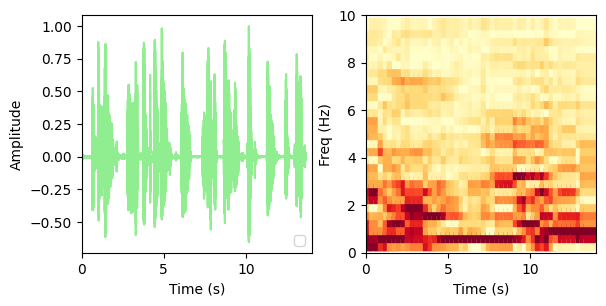

In [ ]:
# !/usr/bin/python3
# rfa_single.py
# Dafydd Gibbon
# Created 2021-08-16
# Modified 2022-04-18
# Code first deposited on GitHub 2021-08-16
# http://www.github.com/dafyddg/RFA

# Note: the code is designed for reading
# and is not optimised or particularly pythonic.
# There is no error trapping or input checking.
# See top level README.1st file.

#===============================================================
#===============================================================
# System and library module import

import sys, re
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wave
from scipy.signal import butter, lfilter
from datetime import datetime
from scipy.signal import medfilt, hilbert
import librosa
# RFA custom module import
# from module_spectrogram import *	# Low frequency spectrogram functions

#===============================================================
#===============================================================
# Assign configuration parameters to variables (see .conf file)
# from rfa_single_conf import *

#===============================================================
wavfilename = "/content/gdrive/MyDrive/EATD_Corpus_Complete/Test/Test_D/negative_out_71.wav"
figurefilename = "AM-spectrogram-ND-neutral_out_82.png"

#===============================================================
#===============================================================
# Mono WAV file input and signal time domain properties
#fs, signal = wave.read(wavfilename)
signal, fs = librosa.load(wavfilename, sr=16000)
#signal = signal[:,0]
# read sampling frequency and signal
signallength = len(signal)		# define numerical signal length
signalseconds = signallength / fs	# define signal length in seconds
signal = signal / max(abs(signal))	# normalise signal scale: -1 ... 0 ... 1

#======================================================
# Envelope demodulation  - the absolute Hilbert Transform is used.
envelope = np.abs(hilbert(signal))
envelope = medfilt(envelope, 701)
envelope = envelope / np.max(envelope)

#===============================================================
# AM low frequency spectral analysis

# FFT of complete envelope, output magnitude values
amspecmags = np.abs(np.fft.rfft(envelope))
amspecmaglen = len(amspecmags)

# Extraction of low frequency spectrum segment
lfamspecmaglen = int(round(amspecfreqmax * amspecmaglen / (fs / 2)))
lfamspecmags = amspecmags[1:lfamspecmaglen]	# DC cutoff
lfamspmMin = min(lfamspecmags)
# Scale to 0...1
lfamspecmags = (lfamspecmags-lfamspmMin) / (np.max(lfamspecmags)-lfamspmMin)

# Assign LF spectrum frequencies to magnitude values
lfamspecfreqs = np.linspace(0,fs/2,amspecmaglen)
lfamspecfreqs = lfamspecfreqs[1:lfamspecmaglen]

# Identification of highest magnitude spectral frequencies
amtopmagscount = magscount
amtopmags = sorted(lfamspecmags)[-amtopmagscount:]
amtoppos = [ list(lfamspecmags).index(m) for m in amtopmags ]
amtopfreqs = [ lfamspecfreqs[p] for p in amtoppos ]

# Redefinition for column chart display
amrhythmbars = lfamspecfreqs
amweightlist = lfamspecmags

#===============================================================
# Create AM spectrogram and max magnitude value trajectory

ammagarray, amfreqarray, ammaxmags, ammaxfreqs = spectrogramarray(
	signal, fs,amspecfreqmin, amspecfreqmax,
	specdownsample, spectrumpower, specwindowsecs, specstrides)

#===============================================================
#===============================================================
# Graphics definition

# Six rows, two columns
# fig,((plt01, plt02), (plt03, plt04)) = plt.subplots(nrows=2, ncols=2, figsize=(figwidth, figheight))
fig,((plt01, plt04)) = plt.subplots(nrows=1, ncols=2, figsize=(figwidth + 1 , 3))
#===============================================================
#===============================================================
# Plot waveform and envelope
xaxistime = np.linspace(0, signalseconds, signallength)
plt01.plot(xaxistime, signal, color="lightgreen")
plt01.set_xlim(0,np.ceil(signalseconds))
plt01.set_xlabel("Time (s)")
plt01.set_ylabel("Amplitude")
# plt01.set_title("(a) Waveform", fontsize=fontsize)
plt01.legend(loc="lower right")


# xaxistime = np.linspace(0, signalseconds, signallength)
# plt02.plot(xaxistime, envelope, color="red", label="AM envelope")
# plt02.set_xlim(0,np.ceil(signalseconds))
# plt02.set_xlabel("Time (s)")
# plt02.set_ylabel("Amplitude")
# plt02.set_title("(b) AM envelope", fontsize=fontsize)
# plt02.legend(loc="lower right")
# plt01.grid()

# #===============================================================
# plt03.plot(lfamspecfreqs, lfamspecmags, color="blue", label="AM LF spectrum")
# plt03.set_xlabel("Freq (Hz)", fontsize=fontsize)
# plt03.set_ylabel("Magnitude", fontsize=fontsize)
# plt03.set_xlim(amspecfreqmin,amspecfreqmax)
# plt03.set_title("(c) AM LF spectrum", fontsize=fontsize)
# plt03.legend(loc="upper right", fontsize=fontsize-2)
# plt02.grid()
#===============================================================
#===============================================================
# AM LF spectrogram in heatmap format
plotspectrogramheatmap(plt04, amfreqarray, ammagarray, signalseconds, amspecfreqmin, amspecfreqmax, specgramdotsize, specheatmaptype, fontsize)

# plt04.set_title("(d) Low Frequency spectrogram", fontsize=fontsize)
#===============================================================
# Graph output
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
plt.savefig(figurefilename)
if showgraph:
	plt.show()








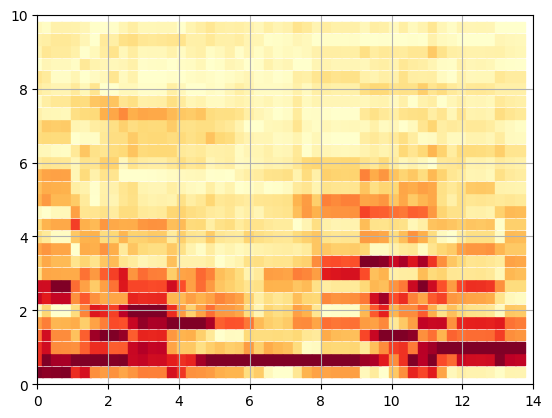

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(480, 640, 3)
480 640 3


In [ ]:
plotspectrogramheatmap1(amfreqarray, ammagarray, signalseconds, amspecfreqmin, amspecfreqmax, specgramdotsize, specheatmaptype, fontsize)
# plt.savefig('/content/gdrive/MyDrive/EATD_Corpus_Complete/Training/Utterances_D/negative_out_9.wav')
fig=plt.gcf()
fig.canvas.draw()
plot_data_rgba = np.array(fig.canvas.renderer.buffer_rgba())
# plt.close()
plot_data_rgb = plot_data_rgba[:, :, :3]
python_list = plot_data_rgb.tolist()
plt.show()
print(plot_data_rgb)
print(plot_data_rgb.shape)
print(len(python_list),len(python_list[0]),len(python_list[0][0]))
# print(ammagarray)
# print(amfreqarray)
# print(ammaxmags.shape)
# print(ammaxfreqs)



## Structural similarity index (SSIM)

In [ ]:
from skimage import io, color, metrics, transform
import numpy as np
# print('The skimage version is {}.'.format(skimage.__version__))
image_1 = io.imread('/content/gdrive/MyDrive/rnd/week4/ND/AM-spectrogram-ND-negative_out_29.png')
image_2 = io.imread('/content/gdrive/MyDrive/rnd/week4/D/AM-spectrogram-D-negative_out_84.png')

image1 = image_1[:, :, :3]
image2 = image_2[:, :, :3]


# Convert the images to grayscale if needed
image1_gray = color.rgb2gray(image1)
image2_gray = color.rgb2gray(image2)


ssim_value = metrics.structural_similarity(image1_gray, image2_gray)

print(f'SSIM of deprssed and non-depressed spectrograms: {ssim_value}')